In this module, we look at designing various camera geometries using `ctapipe.instrument.CameraGeometry` and explore their effects on reconstructing shower parameters 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.instrument import CameraGeometry
from ctapipe.image import dilate, tailcuts_clean, toymodel
from ctapipe.image.hillas import hillas_parameters, HillasParameterizationError
import astropy.units as u
from ctapipe.visualization import CameraDisplay


plt.style.use("dark_background")
plt.rcParams["axes.facecolor"] = "0.2"
plt.rcParams["axes.grid"] = False
plt.rcParams.update({"grid": False})

KeyError: 'grid is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

Designing a Square Grid Camera 

In [96]:
pix_type = "square"
size = 20 # Width of the square pixel in mm
pix_id = np.arange(0,256)

x_sq = (np.arange(-8,8) * size) + size/2.0
y_sq = (np.arange(-8,8) * size) + size/2.0
pix_x_sq, pix_y_sq = np.meshgrid(x_sq, y_sq)


pix_x_sq = pix_x_sq.ravel()*u.mm
pix_y_sq = pix_y_sq.ravel()*u.mm

pix_area_sq = np.power(size/1.05,2)*u.mm**2

geom_sq = CameraGeometry(
                        pix_id=pix_id, 
                        pix_x=pix_x_sq, 
                        pix_y = pix_y_sq, 
                        pix_area=pix_area_sq*np.ones([256]), 
                        pix_type=pix_type, 
                        name="Square Layout") 

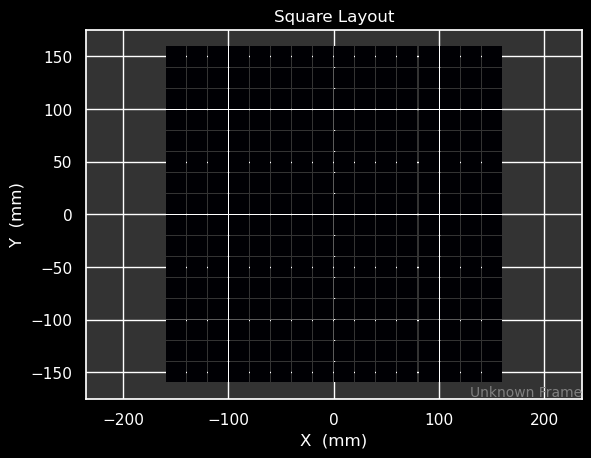

In [102]:
disp1= CameraDisplay(geom_sq, title="Square Layout")

A shower image can be generated using `ctapipe.image.toymodel()`. It supports two modes: Gaussian and skewnessewed Gaussian\
Once the shower model is generated, it can be projected onto the camera layout and displayed

In [76]:
model = toymodel.SkewedGaussian(
    x = 3 * u.mm,
    y = 10 * u.mm,
    length = 50 * u.mm,
    width = 20 * u.mm,
    skewness = 0.6,
    psi = 15.*u.deg
)

`sig_sq` contains signal from the shower, `bg_sq` has the night sky background (nsb) and `image_sq` holds both signal and nsb

In [77]:
image_sq, sig_sq, bg_sq = model.generate_image(geom_sq, intensity=1200, nsb_level_pe=6)

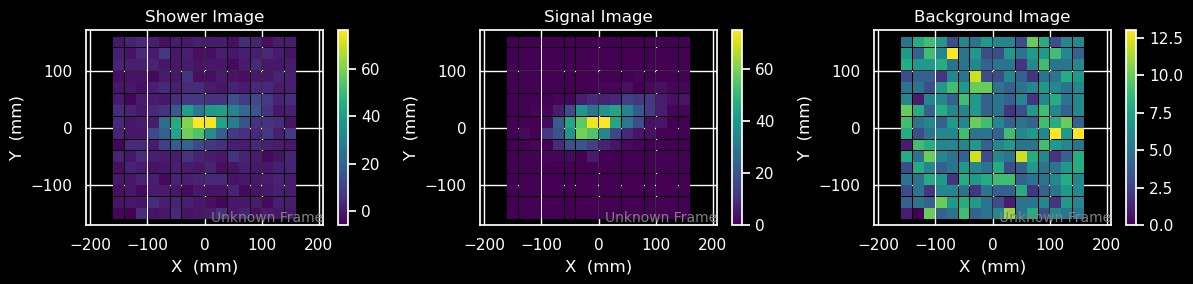

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
disp1 = CameraDisplay(geom_sq, ax = ax[0], title="Shower Image", cmap = 'viridis')
disp1.image = image_sq
disp2 = CameraDisplay(geom_sq, ax = ax[1], title="Signal Image", cmap = 'viridis')
disp2.image = sig_sq
disp3 = CameraDisplay(geom_sq, ax = ax[2], title="Background Image", cmap = 'viridis')
disp3.image = bg_sq

disp1.add_colorbar()
disp2.add_colorbar()
disp3.add_colorbar()
plt.tight_layout()

#### Hillas Parametrization
Observations consist of signal + noise. So the image has to be cleaned of the background before computing the Hillas Parameters
`ctapipe.image.tailcuts_clean` does this and returns a boolean mask of the pixels of the clean image

In [79]:
from pprint import pprint
clean_image_sq_px = tailcuts_clean(geom_sq, image_sq, picture_thresh=10, boundary_thresh=5)
clean_image_sq = image_sq.copy()
clean_image_sq[~clean_image_sq_px] = 0
hillas_params_sq = hillas_parameters(geom_sq, clean_image_sq_px)

A plot of the original image with the clean image pixels highlighter in orange

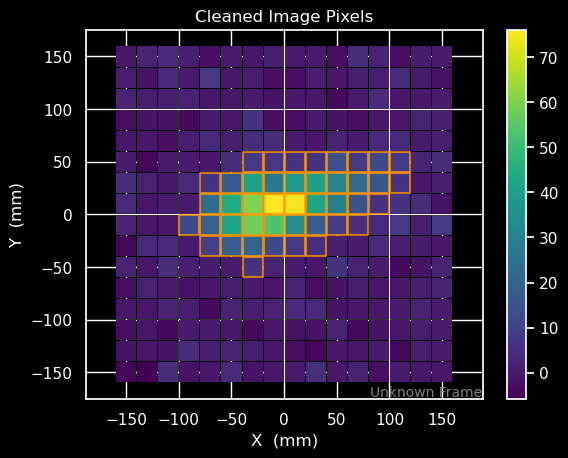

In [80]:
disp_clean = CameraDisplay(geom_sq, title="Cleaned Image Pixels", cmap = 'viridis')
disp_clean.image = image_sq
disp_clean.add_colorbar()
disp_clean.highlight_pixels(clean_image_sq_px, linewidth = 1.5, color = "#FF9A03")

Description of the HillasParameterContainer

In [81]:
pprint(hillas_params_sq)

ctapipe.containers.CameraHillasParametersContainer:
                     intensity: total intensity (size) with default nan
                      skewness: measure of the asymmetry with default nan
                      kurtosis: measure of the tailedness with default nan
                             x: centroid x coordinate with default nan m [m]
                             y: centroid x coordinate with default nan m [m]
                             r: radial coordinate of centroid with default nan m
                                [m]
                           phi: polar coordinate of centroid with default nan
                                deg [deg]
                        length: standard deviation along the major-axis with
                                default nan m [m]
            length_uncertainty: uncertainty of length with default nan m [m]
                         width: standard spread along the minor-axis with
                                default nan m [m]
        

Compare the computed parameters to the input values in the toymodel


In [82]:
print(hillas_params_sq)

{'intensity': np.float64(43.0),
 'kurtosis': np.float64(2.0603460330176286),
 'length': <Quantity 54.96879908 mm>,
 'length_uncertainty': <Quantity 4.31594432 mm>,
 'phi': <Angle 0.90388812 rad>,
 'psi': <Angle 0.25243277 rad>,
 'psi_uncertainty': <Angle 0.09317771 rad>,
 'r': <Quantity 13.91078738 mm>,
 'skewness': np.float64(0.15341848553351528),
 'transverse_cog_uncertainty': <Quantity 2.90473467 mm>,
 'width': <Quantity 25.12832565 mm>,
 'width_uncertainty': <Quantity 1.99829816 mm>,
 'x': <Quantity 8.60465116 mm>,
 'y': <Quantity 10.93023256 mm>}


Overlay the Hillas ellipse and other paramters over the clean image

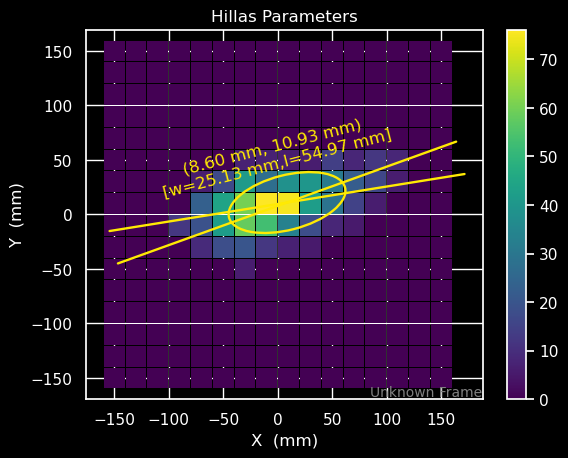

In [83]:
disp_hillas_sq = CameraDisplay(geom_sq, title="Hillas Parameters", cmap = 'viridis')
disp_hillas_sq.image = clean_image_sq
disp_hillas_sq.add_colorbar()
disp_hillas_sq.overlay_moments(hillas_params_sq, color = "#FFEA03", linewidth = 1.7)    

#### Exploring other camera geometries

**1.Brickwall Geometry**\
Every succeeding row is given an offset making the overall layout resemble a "brickwall". This reduces the distance between diagonal pixels resulting in better imaging of curved features seen in showers. The image reproduction quality lies between a square grid and a hex grid

In [84]:
size = 22
pix_id = np.arange(0,256)
x_br = (np.arange(-8,8) * size)+size/2.0 
y_br = (np.arange(-8,8) * size)+size/2.0
pix_x_br, pix_y_br = [], []
for i in range(len(y_br)):
    offset = size/2.0 if i%2==0 else 0
    for j in range(len(x_br)):
        pix_x_br.append(x_br[j]+offset)
        pix_y_br.append(y_br[i])
pix_x_br = np.array(pix_x_br)*u.mm
pix_y_br = np.array(pix_y_br)*u.mm
pix_type = "rectangular"
pix_area_br = np.power(size/1.05,2)*u.mm**2
geom_br = CameraGeometry(
        pix_id=pix_id, 
        pix_x=pix_x_br, 
        pix_y=pix_y_br, 
        pix_area=pix_area_br*np.ones([256]), 
        pix_type=pix_type, 
        name="Brickwall Layout")



**2. Hexagonal Geometry**

In [85]:
pix_type = "hexagonal"
size = 22
pix_id = np.arange(0,256)
pid = np.arange(0,256)
x_h = (np.arange(-8,8) * size)+size/2.0
y_h = (np.arange(-8,8) * size)+size/2.0

pix_x_h, pix_y_h = [], []
for i in range(len(y_h)):
    offset = size/2.0 if i%2==0 else 0
    for j in range(len(x_h)):
        pix_x_h.append(x_h[j]+offset)
        pix_y_h.append(y_h[i])
pix_x_h = np.array(pix_x_h)*u.mm
pix_y_h = np.array(pix_y_h)* u.mm
pix_area_h = np.power(size/1.05,2)*1e-6*u.m**2
geom_hx = CameraGeometry(
        pix_id=pix_id, 
        pix_x=pix_x_h, 
        pix_y = pix_y_h, 
        pix_area=pix_area_h*np.ones([256]), 
        pix_type=pix_type, 
        name="Hexagonal Layout")

   

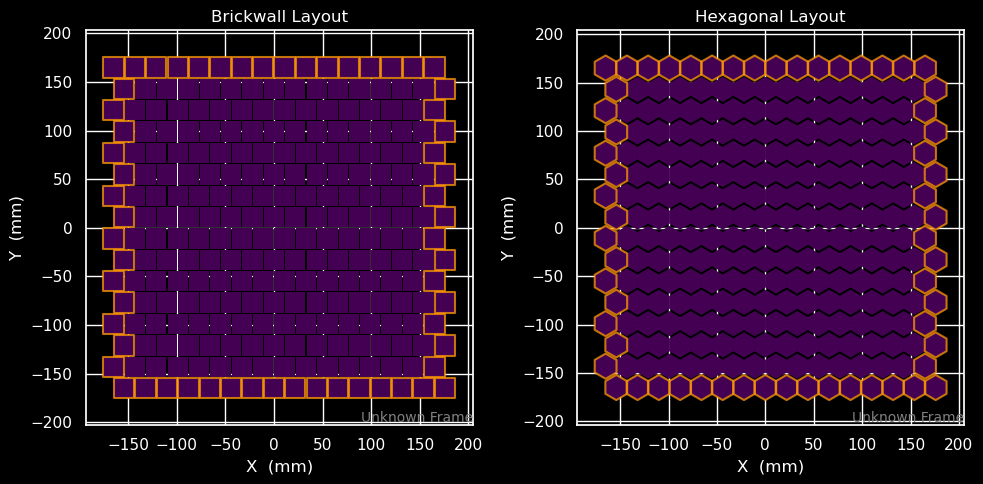

In [86]:
bpx_h = geom_hx.get_border_pixel_mask()
bpx_br = geom_br.get_border_pixel_mask()
size = 22
eps = size * 0.5
pix_x = geom_br.pix_x.to_value(u.mm)
pix_y = geom_br.pix_y.to_value(u.mm)
x_min, x_max = pix_x.min(), pix_x.max()
y_min, y_max = pix_y.min(), pix_y.max()
border_pixels = (
    (np.isclose(pix_x, x_min, atol=eps)) |
    (np.isclose(pix_x, x_max, atol=eps)) |
    (np.isclose(pix_y, y_min, atol=eps)) |
    (np.isclose(pix_y, y_max, atol=eps))
)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
disp_br = CameraDisplay(geom_br, title="Brickwall Layout", cmap = 'viridis', ax=ax[0])
disp_hx = CameraDisplay(geom_hx, title="Hexagonal Layout", cmap = 'viridis', ax=ax[1])
disp_hx.highlight_pixels(bpx_h, color = "#FF9A03", linewidth = 1.5)
disp_br.highlight_pixels(border_pixels, color = "#FF9A03", linewidth = 1.5)
plt.tight_layout()

Problem: 
1. Generate 5000 showers images with a skewness of 0.6. Sample the length and width, rotation angle (psi) and the centroid coordinates from a uniform distribution (Ensure the limits of the distributions are set reasonably for the camera layouts designed. There is no point in generating showers twice the size of the camera itself). Compute the hillas parameters and plot the distribution of the reconstructed skewness. How does it compare to the input (constant) distribution? Which layout was able to reconstruct the parameter the best? Whats the reasoning behind the claim? 
2. Some of the showers could be situated close to the edges of the camera and are partially captured. Use `CamereGeomtry.get_border_pixel_mask` to identify the border pixels and discard shower events that touch these pixels. Recompute the skewness distribution. Do you see an improvement in the reconstructed skewness? 

In [87]:
N = 5000
skewness = 0.6
#CHECKK
psi = np.random.uniform(0, 90, N) * u.deg # 0 to 90 degrees will suffice as anything beyond will just flip the sign of the reco skewness  
length, width = np.random.uniform(20,80, size = N), np.random.uniform(10,25, size = N)                                       

params_sq = {
"x_coord": np.random.uniform(np.min(pix_x_sq.value), np.max(pix_x_sq.value), size = N) * u.mm, 
"y_coord": np.random.uniform(np.min(pix_y_sq.value), np.max(pix_y_sq.value), size = N) * u.mm, 
"skewness": np.ones(N) * skewness,
"psi":  psi 
}

params_br = {
"x_coord": np.random.uniform(np.min(pix_x_br.value), np.max(pix_x_br.value), size = N) * u.mm, 
"y_coord": np.random.uniform(np.min(pix_y_br.value), np.max(pix_y_br.value), size = N) * u.mm, 
"skewness": np.ones(N) * skewness,
"psi": psi 
}

params_h = {
"x_coord": np.random.uniform(np.min(pix_x_h.value), np.max(pix_x_h.value), size = N) * u.mm, 
"y_coord": np.random.uniform(np.min(pix_y_h.value), np.max(pix_y_h.value), size = N) * u.mm, 
"skewness": np.ones(N) * skewness,
"psi": psi 
}
geom_n_param = {
            "geoms": [geom_sq, geom_br, geom_hx],
            "params": [params_sq, params_br, params_h]
}


intensity = 1200 # pe
bg = 6 

contained_events = [[],[],[]] # Boolean list to keep track of whether each event is contained or not for each geometry
length_reco_all, width_reco_all = [[],[],[]], [[],[],[]]
skewness_all = [[],[],[]]

x_reco_all = [[],[],[]]
y_reco_all = [[],[],[]]

for ind, (geom, param) in enumerate(zip(geom_n_param["geoms"], geom_n_param["params"])):
    size = 22.1
    eps = size * 0.5
    pix_x = geom.pix_x.to_value(u.mm)
    pix_y = geom.pix_y.to_value(u.mm)
    x_min, x_max = pix_x.min(), pix_x.max()
    y_min, y_max = pix_y.min(), pix_y.max()

    border_pixels = (
        (np.isclose(pix_x, x_min, atol=eps)) |
        (np.isclose(pix_x, x_max, atol=eps)) |
        (np.isclose(pix_y, y_min, atol=eps)) |
        (np.isclose(pix_y, y_max, atol=eps))
    )
    for i in range(len(param["x_coord"])):
        
        x = param["x_coord"][i]
        y = param["y_coord"][i]
        sk = param["skewness"][i]
        psi = param["psi"][i]
        

        try:

            model = toymodel.SkewedGaussian(x, y, length = length[i]* u.mm , width= width[i] * u.mm, skewness= sk, psi = psi)

            image, sig, bg = model.generate_image(geom, intensity=intensity, nsb_level_pe=bg)

            mask = tailcuts_clean(geom, image, picture_thresh=10, boundary_thresh=5)

            clean = image.copy()
            clean[~mask] = 0.
            # Check if image touches border pixels
            image_pixels = (clean>0)
            hillas = hillas_parameters(geom, clean)
            touches_border = np.any(image_pixels & border_pixels)
            
            skewness_all[ind].append(hillas.skewness)
            length_reco_all[ind].append(hillas.length)
            width_reco_all[ind].append(hillas.width)
            x_reco_all[ind].append(hillas.x)
            y_reco_all[ind].append(hillas.y)


            if ~touches_border:
                contained_events[ind].append(True)

            else:
                contained_events[ind].append(False)

                continue



        except HillasParameterizationError:
            print("Error")
            skewness_all[ind].append(np.nan)
            contained_events[ind].append(False)
            length_reco_all[ind].append(np.nan * u.mm)
            width_reco_all[ind].append(np.nan * u.mm)
            x_reco_all[ind].append(np.nan * u.mm)
            y_reco_all[ind].append(np.nan * u.mm)
            continue



In [88]:
import pandas as pd
rows = []

for ind, (geo, par) in enumerate(zip(geom_n_param["geoms"], geom_n_param["params"])):
    name = geo.name
    x = par['x_coord']
    y = par['y_coord']
    sk = par['skewness']
    psi = par['psi']

    
    for i, (xv, yv,skv, psiv) in enumerate(zip(x, y, sk, psi)): 
        rows.append({
            "Geometry" : name,
            "length": length[i],
            "length_reco": length_reco_all[ind][i].value,
            "width": width[i],
            "width_reco": width_reco_all[ind][i].value,
            "x coord_input": xv,
            "x_coord_reco": x_reco_all[ind][i],
            "y_coord_input": yv,
            "y_coord_reco": y_reco_all[ind][i], 
            "skewness_input": sk[i],
            "skewness_reco": skewness_all[ind][i],
            "psi": psi[i],
            "contained_flag": contained_events[ind][i]
        })        
    df = pd.DataFrame(rows)
    


In [89]:
df

,Geometry,length,length_reco,width,width_reco,x coord_input,x_coord_reco,y_coord_input,y_coord_reco,skewness_input,skewness_reco,psi,contained_flag
0,Square Grid,75.124196,64.049117,11.513883,10.822081,-42.19416927330096 mm,-42.3157758764798 mm,-6.98200815931159 mm,-9.686108536084982 mm,0.6,0.342733,79.21960105121522 deg,False
1,Square Grid,76.540724,46.316414,13.438108,13.995859,119.67714629534902 mm,83.94900721354153 mm,121.65488135461317 mm,110.56761647428912 mm,0.6,-0.396421,14.259342766730647 deg,False
2,Square Grid,61.803829,58.941948,12.361413,16.204392,46.65743807450161 mm,45.53520005788293 mm,2.981790673167609 mm,2.467115259387888 mm,0.6,-0.293952,88.65041110801383 deg,False
3,Square Grid,66.555426,59.748501,16.134988,22.441048,54.727718681374995 mm,35.85503108373935 mm,109.95177999056102 mm,78.77764958790182 mm,0.6,-1.165171,59.02185637396508 deg,False
4,Square Grid,39.069753,40.388266,20.967734,27.273061,-39.69952757963357 mm,-34.01517362124307 mm,109.31049801974291 mm,95.76426797241419 mm,0.6,2.034495,81.64633245570533 deg,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Hexagonal Layout,51.256459,37.414853,22.598469,14.678985,-107.68652021321476 mm,-112.662100456621 mm,163.4793816306509 mm,152.47640791476408 mm,0.6,0.522045,18.25893047466191 deg,False
14996,Hexagonal Layout,32.732433,31.641408,14.245424,14.294416,117.67868101021247 mm,117.33333333333333 mm,93.50858349074872 mm,91.9367327667611 mm,0.6,0.420598,67.43811594955153 deg,False
14997,Hexagonal Layout,46.112981,32.384294,12.494186,11.538784,-147.7459140868025 mm,-130.26081081081082 mm,-93.84089838266198 mm,-87.73243243243243 mm,0.6,0.764006,21.954485227780225 deg,False
14998,Hexagonal Layout,44.188266,38.483329,21.837151,21.019303,3.747341895216266 mm,4.0638297872340425 mm,-5.3187630220121775 mm,-8.48936170212766 mm,0.6,0.291328,72.08374464170356 deg,True


In [90]:
df_contained = df[df["contained_flag"] == True]
df_contained[df_contained["Geometry"] == "Square Grid"]["skewness_input"]

1134    0.6
1223    0.6
1231    0.6
1234    0.6
1241    0.6
       ... 
4983    0.6
4985    0.6
4988    0.6
4991    0.6
4998    0.6
Name: skewness_input, Length: 723, dtype: float64

In [ ]:
valuecounts_sq = df_contained[df_contained["Geometry"] == "Square Grid"]["skewness_input"].value_counts()
valuecounts_br = df_contained[df_contained["Geometry"] == "Square Grid"]["skewness_input"].value_counts()

Square Grid
	Mean: 0.36	Standard Deviation: 0.16
Brickwall Layout
	Mean: 0.37	Standard Deviation: 0.15
Hexagonal Layout
	Mean: 0.40	Standard Deviation: 0.14


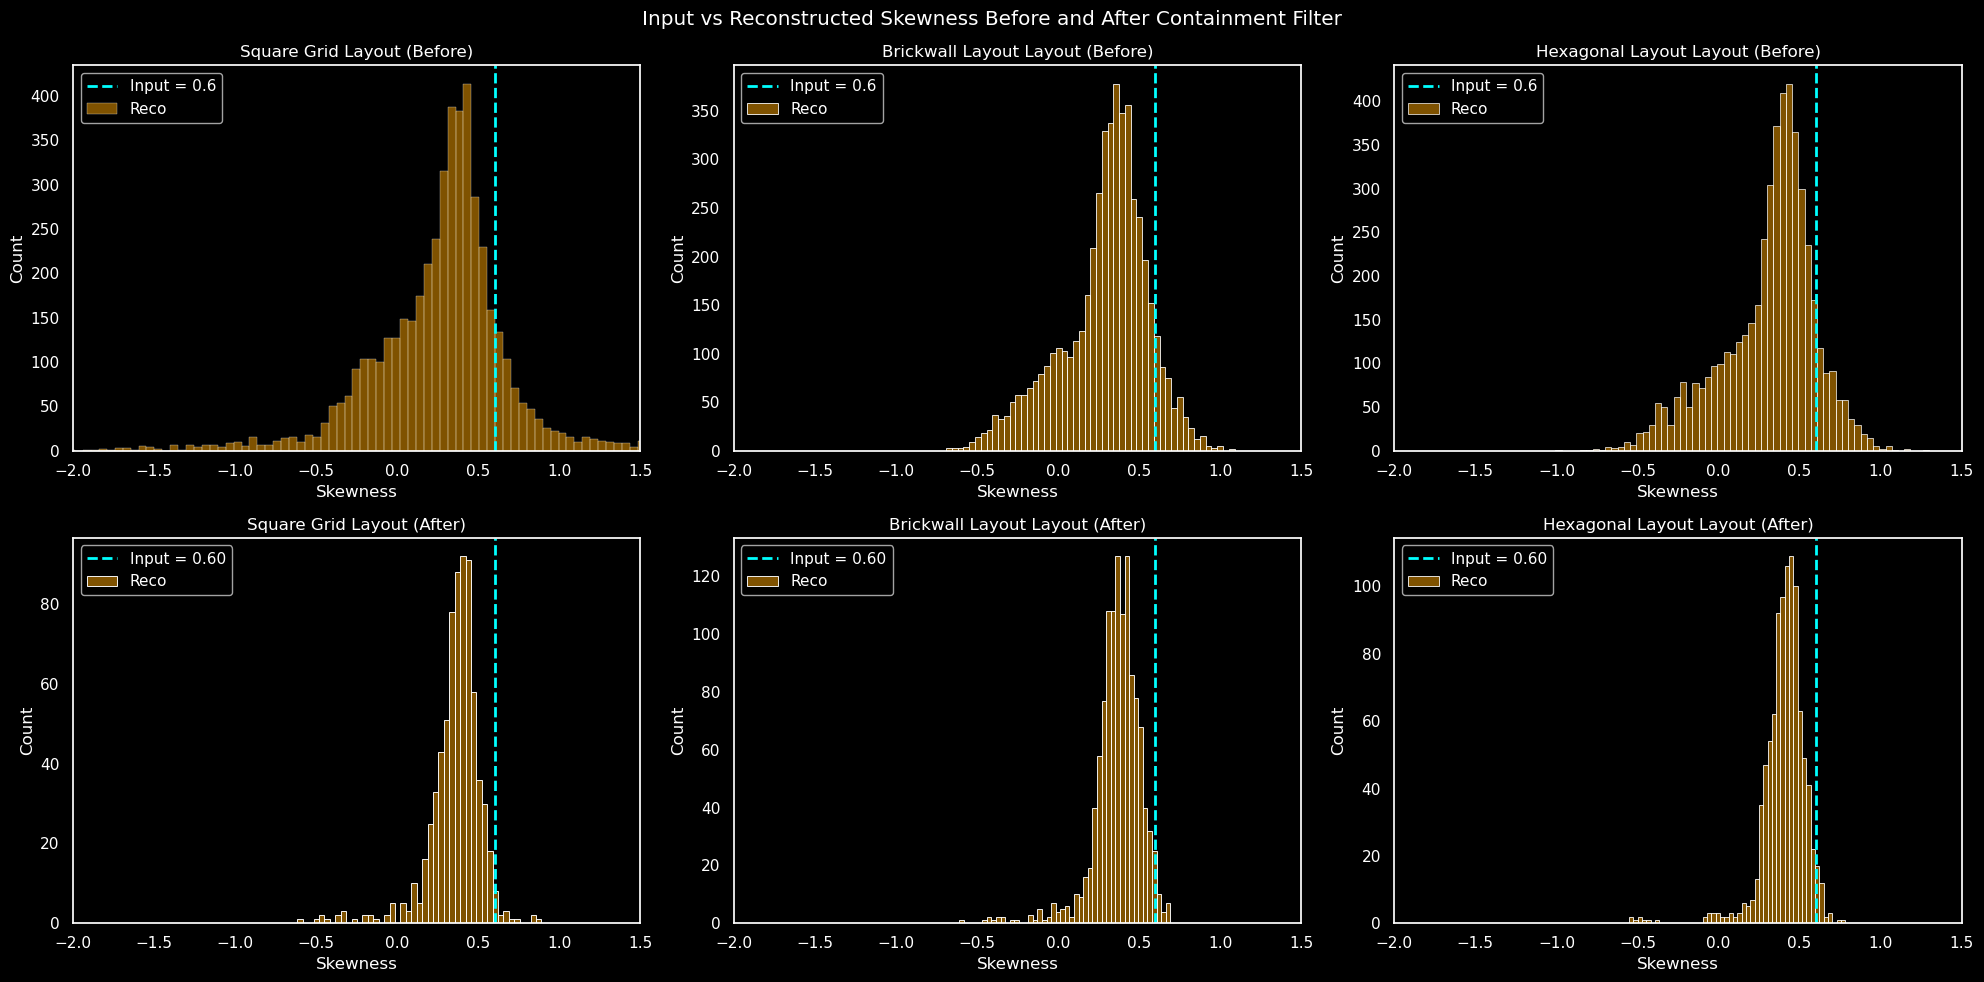

In [91]:
import seaborn as sns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
sns.set_theme(font_scale=1)
plt.style.use("dark_background")

plt.rcParams.update({"text.color": "white"})
# BEFORE CONTAINMENT
for ind, geom in enumerate(geom_n_param["geoms"]):
    name = geom.name

    skewness_i = df[df["Geometry"] == name]["skewness_input"].iloc[0]
    skewness_r = df[df["Geometry"] == name]["skewness_reco"]

    ax = axes[ind]
    ax.grid(False)

    sns.histplot(skewness_r, ax=ax, kde=False, color="orange", alpha=0.5, label="Reco")
    ax.axvline(skewness_i, color="cyan", linestyle="--", linewidth=2,
               label=f"Input = {skewness_i}")
    ax.set_xlim(-2, 1.5)
    ax.set_title(f"{name} Layout (Before)")
    ax.set_xlabel("Skewness")
    ax.set_ylabel("Count")
    ax.legend()

# AFTER CONTAINMENT
for ind, geom in enumerate(geom_n_param["geoms"]):
    name = geom.name
    skewness_i = df_contained[df_contained["Geometry"] == name]["skewness_input"].iloc[0]
    skewness_r = df_contained[df_contained["Geometry"] == name]["skewness_reco"]

    ax = axes[ind + 3]   # second row
    ax.grid(False)

    sns.histplot(skewness_r, ax=ax, kde=False, color="orange", alpha=0.5, label="Reco")
    ax.axvline(skewness_i, color="cyan", linestyle="--", linewidth=2,
               label=f"Input = {skewness_i:.2f}")

    ax.set_title(f"{name} Layout (After)")
    ax.set_xlabel("Skewness")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_xlim(-2, 1.5)
    print(f"{name}\n\tMean: {np.mean(skewness_r):.2f}\tStandard Deviation: {np.std(skewness_r):.2f}")
    plt.suptitle("Input vs Reconstructed Skewness Before and After Containment Filter")
    
plt.tight_layout()
plt.show()
